# Probabilistic Data Analysis


   Probabilistic data analysis -- including Bayesian inference, requires to draw samples from distributions to 

- Compute the mean and covariance of the model parameters
- Compute expectation value of a function of the model parameters
- Compute marginal distributions of the model parameters

This section will introduce different Monte Carlo methods to draw samples $\theta \in R^{N_{\theta}}$ from the posterior distribution

$$ p(\theta|y) = \frac{1}{Z} p(y|\theta) p_0(\theta) $$

where the prior distribution $p_0(\theta)$ and the likelihood function $p(y|\theta)$ can be relatively
easily computed from any particular value $(\theta, y)$, but the normalization $Z$ is diffucult to compute.

In the following, we will demonstrate 

1. random walk Metropolis-Hastings method
2. affine invariant Markov chain Monte Carlo ensemble sampler
4. sequential Monte Carlo sampler 

on the 2-dimensional Rosenbrock likelihood function with prior $\mathcal{N}(0, 10^2 I)$

$$\pi(\theta_{(1)}, \theta_{(2)}) \propto \exp\Big(-\frac{100(\theta_{(2)} - \theta_{(1)}^2)^2 + (1 - \theta_{(1)})^2}{20}\Big)\frac{1}{200\pi}\exp\Big(-\frac{\theta_{(1)}^2 + \theta_{(2)}^2}{200}\Big)$$


The posterior distribution is derived from the following inverse problem:

$$y = \mathcal{G}(\theta) + \eta$$

with 

$$
y = 
\begin{bmatrix}
0\\
1
\end{bmatrix} \qquad 
\mathcal{G}(\theta) 
=
\begin{bmatrix}
\theta_{(2)} - \theta_{(1)}^2\\
\theta_{(1)}
\end{bmatrix} \qquad
\Sigma{\eta}
=
\begin{bmatrix}
\frac{1}{10}  & \\
0 & 10
\end{bmatrix}
$$




In [28]:
μ0, σ0 = [0.0;0.0], 10.0
Σ0 = [σ0^2 0.0;0.0  σ0^2]

ση₁, ση₂ = sqrt(1/10), sqrt(10)

Ση = [ση₁^2  0.0;  0.0  ση₂^2]
y = [0.0; 1.0]


function func_G(s_param, θ::Array{Float64,1})
    θ₁, θ₂ = θ
    return [θ₂ - θ₁^2; θ₁]
end

function log_Rosenbrock(θ::Array{Float64,1})
    θ₁, θ₂ = θ
    return (-(θ₂ - θ₁^2)^2/ση₁^2 - (1 - θ₁)^2/ση₂^2  -(θ₁^2 + θ₂^2)/σ0^2)/2
end

Rosenbrock = (θ) -> exp(log_Rosenbrock(θ));

# Markov Chain

A Markov chain is a stochastic process $\{\theta(t)\}$ 
for which the distribution of $\theta(t)$ depends only on $\theta(t-1)$
    
$$P\big(\theta(t) = \theta_t |\theta(0)= \theta_0,\, \theta(1)= \theta_1,\, ..., \theta(t−1)= \theta_{t-1}\big) = P\big(\theta(t) = \theta_t |\theta(t-1) = \theta_{t-1}\big)$$

for all $t$ and $\theta$. A **time-homogeneous** Markov chain has the transition probabilities $f(\theta'|\theta)$: 

$$f(\theta'|\theta) = P\big(\theta(t) = \theta' |\theta(t-1) = \theta \big)$$

for all $t$. The stationery distribution $\pi$ of the homogeneous Markov chain satisfies

$$\pi(\theta') = \int f(\theta'|\theta) \pi(\theta) d\theta $$

which is equivalent to that, if $\theta_{t-1} \sim \pi$ then $\theta_{t} \sim \pi$ 

A sufficient but not necessary condition for $\pi$ to be the stationery distribution is the detailed balance

$$\pi(\theta)f(\theta'|\theta) = \pi(\theta')f(\theta|\theta')$$

The Markov chain is **irreducible**, if all states communicate with each other. The Markov chain is **aperiodic**, if all states are aperiodic.

The idea behind the Markov Chain Monte Carlo (MCMC), is to build a time-homogeneous, irreducible, and aperiodic Markov chain, whose stationery distribution $\pi$ is the posterior distribution. Since the limiting distribution of such Markov chains exists and is equal to $\pi$.  Therefore, sampling the posterior distribution becomes sampling from the chain.



# Random Walk Metropolis-Hastings Method


The Metropolis-Hastings method builds the transition probabilities $f(\theta'|\theta)$  with detailed balance:

$$\pi(\theta)f(\theta'|\theta) = \pi(\theta')f(\theta|\theta')$$

The Metropolis-Hastings method starts with a proposal distribution $q(\theta'|\theta)$, and the acceptance function $A(\theta'|\theta)$. The transition probability can be written as 

$$f(\theta'|\theta) = q(\theta'|\theta) A(\theta' | \theta)$$

The common choice of $A$, that leads to staionary distribution $\pi(\theta)$,  is the Metropolis choice

$$A(\theta'|\theta) = \min \Big(1, \frac{\pi(\theta') q(\theta|\theta')}{\pi(\theta) q(\theta'|\theta)}\Big)$$


The algorithm is 

- Propose a random candidata $\theta'$ according to $q(\theta'|\theta(t))$
- Calculate the acceptance probability $A(\theta'|\theta) = \min \Big(1, \frac{\pi(\theta') q(\theta(t)|\theta')}{\pi(\theta(t)) q(\theta'|\theta(t))}\Big)$
- Generate a uniform random number $u \sim [0, 1]$
    - if $u \leq A(\theta'| \theta(t))$, accept the proposal $\theta(t+1) =  \theta'$,
    - if $u > A(\theta'| \theta(t))$, reject the proposal and copy the old state $\theta(t+1) =  \theta(t)$.


The random walk Metropolis-Hastings method chooses the proposal distribution $q(\theta'|\theta)$ to be

$$ q(\theta'|\theta) \sim N(\theta , \Sigma_q) $$

which is symmetric, $q(\theta'|\theta) = q(\theta|\theta')$.

In [29]:
include("../Inversion/Plot.jl")
include("../Inversion/RWMCMC.jl")
using LinearAlgebra

# compute posterior distribution by MCMC

step_length = 0.1
n_ite = 10000000
us = RWMCMC_Run(log_Rosenbrock, μ0, step_length, n_ite);

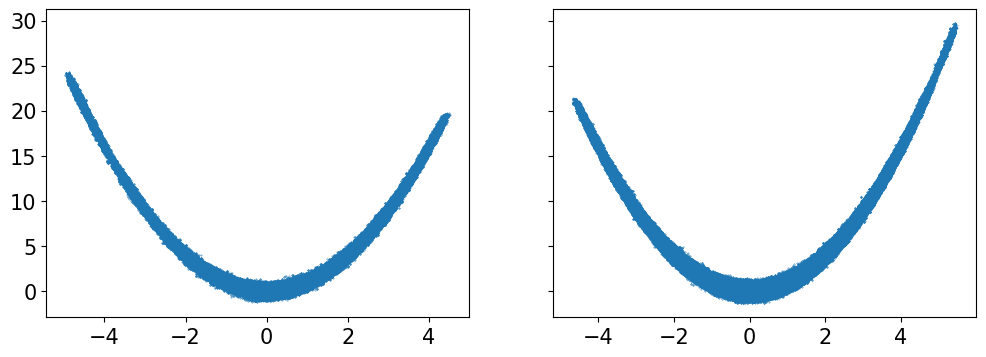

PyObject <matplotlib.collections.PathCollection object at 0x7fc51161c790>

In [30]:
everymarker = 1
fig, ax = PyPlot.subplots(ncols=2, sharex=false, sharey=true, figsize=(12,4))
n_burn_in, n_end = 10^5, 10^6
ax[1].scatter(us[n_burn_in:everymarker:n_end, 1], us[n_burn_in:everymarker:n_end, 2], s = 0.1, label="MCMC ($(n_end))")
ax[1].legend()
n_burn_in, n_end = 10^6, 10^7
ax[2].scatter(us[n_burn_in:everymarker:n_end, 1], us[n_burn_in:everymarker:n_end, 2], s = 0.1, label="MCMC ($(n_end))")
ax[2].legend()

# Challenges and Improvements: Automatic Tuning

In practice the Metropolis-Hastings algorithm requires tuning of some internal variables before the MCMC simulator works effectively in practice. The efficiency of the method is affected by the scale and
orientation of the proposal distribution. When the distribution is too wide, too many candidates are rejected; When the distribution is too narrow, the distance moved is too small. This motivates the automatic tuning of the proposal distribution.

Examples of such methods are the **Adaptive Proposal** and **Adaptive
Metropolis** schemes presented in [1,2], respectively. These algorithms utilize a
single Markov chain and continuously adapt the covariance, $\Sigma_q$ of a Gaussian proposal
distribution, using the information contained in the sample path of
the chain

$$\Sigma_{q}(t) = s_d \textrm{Cov}(\theta(0),\,\theta(1),\,\cdots, \theta(t-1)) + s_d\epsilon I$$

where $s_d = 2.4^2/N_{\theta}$ represents a scaling factor. $I$ signifies the identity
matrix, and $\epsilon$ is a constant with a small value compared to that of the target so that the
whole parameter space can be reached.


1. Haario, Heikki, Eero Saksman, and Johanna Tamminen. "Adaptive proposal distribution for random walk Metropolis algorithm."
2. Haario, Heikki, Eero Saksman, and Johanna Tamminen. "An adaptive Metropolis algorithm."

# Challenges and Improvements: Ensemble Samplers

A single chain is unable to efficiently cope with the numerous local optima in complex posterior surfaces, 
and traverse well in pursuit of sampling the target distribution. This motivates the MCMC ensemble samplers, 
where $K$ different Markov Chains are run simulataneously in parallel, and meanwhile interact with each other.  

These methods involve simulataneously evolving an ensemble of $K$ particles $S(t) = \{\theta^k(t)\}_k$, 
The proposal of the $k$-th Markov Chain has the following general form

$$\theta^{'k}(t+1) = \theta^{k}(t) + \gamma (\theta^{j_1}(t) - \theta^{j_2}(t)) + e$$

The interation is embedded in the (random) sampled particles $\theta^{j_1}$ and $\theta^{j_2}$, which automatically selects an appropriate scale and orientation of the proposal distribution en route to the target
distribution. 
Second, heavy-tailed and multimodal target distributions are efficiently
accommodated, as the usage of the current location of the chains,
instead of $Cov(\theta)$. And the proposed candidate points allow the
possibility of direct jumps between one mode to another.


There are several successful MCMC ensemble samplers, the Differential Evolution-Markov Chain method (DE-MC)[1], the DiffeRential Evolution Adaptive Metropolis (DREAM)[2], and the Affine Invariant Markov Chain Monte Carlo Ensemble Sampler (emcee)[3].

1. Ter Braak, Cajo JF. "A Markov Chain Monte Carlo version of the genetic algorithm Differential Evolution: easy Bayesian computing for real parameter spaces." 
2. Vrugt, Jasper A., James M. Hyman, Bruce A. Robinson, Dave Higdon, Cajo JF Ter Braak, and Cees GH Diks. "Accelerating Markov chain Monte Carlo simulation by differential evolution with self-adaptive randomized subspace sampling."
3. Goodman, Jonathan, and Jonathan Weare. "Ensemble samplers with affine invariance."

# Affine Invariant Markov Chain Monte Carlo Ensemble sampler

The affine-invariant ensemble sampler for Markov chain Monte Carlo is the most popular MCMC method, since it requires fewer function calls per independent sample and is easy to parallelize.
This method involves simultaneously evolving an ensemble of $K$ walkers $S(t) = \{\theta^k(t)\}_k$, and the idea behind is the partial resampling.
 
## Sequential Version 
 
The algorithm is sequential for $k = 1,\cdots K$
- Draw a walker $\theta^j(t)$ at random from the complementary ensemble $S_{[k]}(t)$

    $$S_{[k]}(t) = \{\theta^1(t+1),\,\cdots \theta^{k-1}(t+1),\,\theta^{k+1}(t),\,\cdots \theta^{K}(t)\}$$
    
- Generate $z \sim g(z)$, where 
$$g(z) \propto \begin{cases} \frac{1}{\sqrt{z}} & \textrm{if } z\in [\frac{1}{a}, a]\\ 0 & \textrm{otherwise}\end{cases} \qquad a = 2$$
- Propose a random candidata 
    $$\theta' = \theta^{j}(t) + z\Big[\theta^k(t) - \theta^{j}(t)\Big]$$ 
- Calculate the acceptance probability 
    $$A(\theta'|\theta^{k}) = \min \Big(1, z^{N_{\theta}-1}\frac{p(\theta')}{p(\theta^{k}(t))} \Big)$$
- Generate a uniform random number $u \sim [0, 1]$
    - if $u \leq A(\theta'| \theta^k(t))$, accept the proposal $\theta^{k}(t+1) =  \theta'$,
    - if $u > A(\theta'| \theta^k(t))$, reject the proposal and copy the old state $\theta^{k}(t+1) =  \theta^{k}(t)$.

$z$ can be generated as $z = \frac{\Big((a-1)u + 1\Big)^2}{a}$, where $u\sim[0,1]$ is a uniform random number.


## Parallel Version 

The parallel implementation split the full ensamle into two subsets 

$$S^{(0)}(t) = \{\theta^1(t),\,\cdots \theta^{K/2}(t)\} 
\qquad S^{(1)}(t) = \{\theta^{K/2+1}(t),\,\cdots \theta^{K}(t)\}$$
    
For $i \in\{0, 1\}$

The algorithm is parallel for $k = 1,\cdots, K/2 $ or $ k = K/2+1,\cdots, K$
- Draw a walker $\theta^j(t)$ at random from the complementary ensemble $S^{(\sim i)}(t)$    
- Generate $z \sim g(z)$, where 
$$g(z) \propto \begin{cases} \frac{1}{\sqrt{z}} & \textrm{if } z\in [\frac{1}{a}, a]\\ 0 & \textrm{otherwise}\end{cases} \qquad a = 2$$
- Propose a random candidata 
    $$\theta' = \theta^{j}(t) + z\Big[\theta^k(t) - \theta^{j}(t)\Big]$$ 
- Calculate the acceptance probability 
    $$A(\theta'|\theta^{k}) = \min \Big(1, z^{N_{\theta}-1}\frac{p(\theta')}{p(\theta^{k}(t))} \Big)$$
- Generate a uniform random number $u \sim [0, 1]$
    - if $u \leq A(\theta'| \theta^k(t))$, accept the proposal $\theta^{k}(t+1) =  \theta'$,
    - if $u > A(\theta'| \theta^k(t))$, reject the proposal and copy the old state $\theta^{k}(t+1) =  \theta^{k}(t)$.

1. Foreman-Mackey, Daniel, David W. Hogg, Dustin Lang, and Jonathan Goodman. "emcee: the MCMC hammer."

# Gibbs Sampling

Gibbs sampling is a special Metropolis-Hastings algorithm, specifically for high-dimensional parameter vectors. 
Suppose we want to sample $\theta = (\theta_{(1)},\,\theta_{(2)},\cdots \theta_{(N_{\theta})})$ from the joint distribution $p(\theta)$, but it is easy to sample from a conditional distribution.  We can sample its components sequentially

\begin{align*}
&\theta_{(1)}(t+1) \sim p\big(\theta_{(1)}| \theta_{(2)}(t),\cdots \theta_{(N_{\theta})}(t)\big) \\
&\theta_{(2)}(t+1) \sim p\big(\theta_{(2)}| \theta_{(1)}(t+1), \theta_{(3)}(t),\cdots \theta_{(N_{\theta})}(t)\big) \\
&\qquad \vdots\\
&\theta_{(N_{\theta})}(t+1) \sim p\big(\theta_{(N_{\theta})}| \theta_{(1)}(t+1),\cdots \theta_{(N_{\theta}-1)}(t+1)\big) \\
\end{align*}

The transition kernel is 

$$
\begin{align*}
f(\theta' | \theta)d\theta' =
p\big(\theta'_{(1)}| \theta_{(2)}(t),\cdots \theta_{(N_{\theta})}(t)\big)
p\big(\theta'_{(2)}| \theta_{(1)}(t+1), \theta_{(3)}(t),\cdots \theta_{(N_{\theta})}(t)\big)\cdots
p\big(\theta'_{(N_{\theta})}| \theta_{(1)}(t+1),\cdots \theta_{(N_{\theta}-1)}(t+1)\big)  d\theta'
\end{align*}
$$

We need to prove that $p$ is the stationery distribution:
$$
\begin{align*}
\int f(\theta' | \theta) p(\theta)d\theta = p(\theta')
\end{align*}
$$
Since (for simplicity, considering $N_{\theta} = 2$) 
$$
\begin{align*}
 &\int p\big(\theta'_{(1)}| \theta_{(2)}(t)\big) p\big(\theta'_{(2)}| \theta'_{(1)}(t)\big) p\big(\theta_{(1)}(t), \theta_{(2)}(t)\big) d\theta \\
=&\int \frac{p\big(\theta'_{(1)}, \theta_{(2)}(t)\big)}{p\big(\theta_{(2)}(t)\big)} 
       \frac{p\big(\theta'_{(1)}, \theta'_{(2)}(t)\big)}{p\big(\theta'_{(1)}(t)\big)}  
       p\big(\theta_{(1)}(t), \theta_{(2)}(t)\big) d\theta \\
=&p\big(\theta'_{(1)}(t),\theta'_{(2)}(t)\big)
\end{align*}
$$

It is worth mentioning the above Gibbs sampling does not satisfy detailed balance.

# Partial Resampling

The idea behind Gibbs sampling can be generalized to partial resampling, where part of the random variables 
is replaced based on correct conditional distribution.

For example,  let denote 

$$\theta = (\theta_{(k)}, \theta_{[-k]})$$

partial resampling in its simplest form, replaces $\theta_{(k)}$ by 
independent sample $\theta^{'}_{(k)}$ with certain transition rule 
$f(\theta_{(k)} \rightarrow \theta^{'}_{(k)} | \theta_{[-k]})$.  

Since $\theta(t) \sim p(\theta)$, $\theta_{[-k]}(t)$ has the correct marginal distribution. The conditional distribution $\theta_{(k)}(t+1)| \theta_{[-k]}(t)$ is designed such that  $\theta(t+1) \sim p(\theta)$. 
When the transition rule leaves the conditional distribution $p(\theta_{(k)} | \theta_{[-k]})$ invariant:

$$\int p(\theta_{(k)} | \theta_{[-k]}) f(\theta_{(k)} \rightarrow \theta^{'}_{(k)} | \theta_{[-k]}) d\theta_{(k)} = p(\theta^{'}_{(k)} | \theta_{[-k]})$$

also leaves $p(\theta)$ invariant:

\begin{align*}
    \int &p(\theta_{(k)} , \theta_{[-k]}) f(\theta_{(k)} \rightarrow \theta^{'}_{(k)} | \theta_{[-k]}) d\theta_{(k)} \\
    & = p(\theta_{[-k]}) \int p(\theta_{(k)} | \theta_{[-k]}) f(\theta_{(k)} \rightarrow \theta^{'}_{(k)} | \theta_{[-k]}) d\theta_{(k)}\\
    & = p(\theta_{[-k]}) p(\theta^{'}_{(k)} | \theta_{[-k]})  = p(\theta^{'}_{(k)} , \theta_{[-k]})
\end{align*}

Therefore, we only need to design transitional kernel that leaves conditional distribution $p(\theta_{(k)} | \theta_{[-k]})$ invariant, and this condition is achieved using detailed balance.


1. [Goodman, Jonathan, "Lecture Notes on Monte Carlo Methods."](https://www.math.nyu.edu/faculty/goodman/teaching/MonteCarlo2005/notes/Nov22/MCMC.pdf)

2. Liu, Jun S, "Monte Carlo strategies in scientific computing." (Page 161)

As for the **sequential version** of the Affine Invariant Markov Chain Monte Carlo Ensemble sampler, the target distribution for the ensemble is the one in which the walkers are independent and drawn
from $p$, that is 

$$\Pi(\theta^1,\,\theta^2,\,\cdots\theta^K) = p(\theta^1)p(\theta^2)\cdots p(\theta^K)$$

The partial resampling will replaces one random choosen worker $\theta^k$ to $\theta^{'k}$ for randomly sampled $j$, while maintains the target distribution $\Pi$. The detailed balance for  

$$\int p(\theta^{k} | S_{[k]}) f(\theta^{k} \rightarrow \theta^{' k} | S_{[-k]}) d\theta_{(k)} 
= p(\theta^{' k} | S_{[-k]})$$

is 

$$ p(\theta^{ k} | S_{[k]}) f(\theta^{k} \rightarrow \theta^{' k} | S_{[-k]}) 
=  p(\theta^{'k} | S_{[k]}) f(\theta^{'k} \rightarrow \theta^{k} | S_{[-k]}) $$

The streching moving is designed that 
$$q(\theta^{k} \rightarrow \theta^{' k} | S_{[-k]})  = q(\theta^{'k} \rightarrow \theta^{k} | S_{[-k]})$$

And the conditional distribution of $p(y | S_{[k]})$ on the ray is 

$$\pi(y) \lVert y-\theta^j\rVert^{N_{\theta} - 1}$$

which leads to the accept probability 

$$A(\theta'|\theta^{k}) 
= \min \Big(1, \frac{\lVert \theta'-\theta^j\rVert^{N_{\theta} - 1}}{\lVert \theta^k-\theta^j\rVert^{N_{\theta} - 1}}\frac{p(\theta')}{p(\theta^{k}(t))} \Big) 
= \min \Big(1, z^{N_{\theta}-1}\frac{p(\theta')}{p(\theta^{k}(t))} \Big)$$

In [31]:
include("../Inversion/Plot.jl")
include("../Inversion/RWMCMC.jl")

# compute posterior distribution by Affine invariant MCMC
N_ens = 1000
θ0 = rand(MvNormal(μ0, Σ0), N_ens)
θ0 = Array(θ0')
n_ite = 1000
us = emcee_Run(log_Rosenbrock, θ0, n_ite);

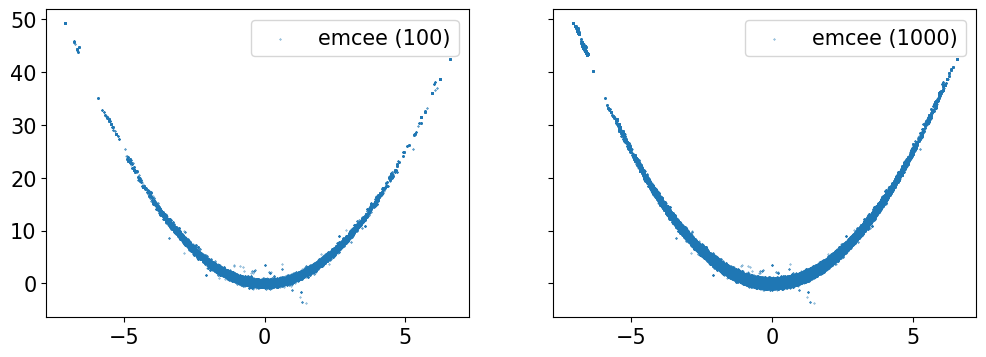

PyObject <matplotlib.legend.Legend object at 0x7fc50a0cabe0>

In [38]:
everymarker = 1
fig, ax = PyPlot.subplots(ncols=2, sharex=false, sharey=true, figsize=(12,4))
n_burn_in, n_end = 40, 100
ax[1].scatter(us[n_burn_in:everymarker:n_end, :, 1], us[n_burn_in:everymarker:n_end, :, 2], s = 0.1, label="emcee ($(n_end))")
ax[1].legend()
n_burn_in, n_end = 40, 1000
ax[2].scatter(us[n_burn_in:everymarker:n_end, :, 1], us[n_burn_in:everymarker:n_end, :, 2], s = 0.1, label="emcee ($(n_end))")
ax[2].legend()


# Important Sampling 

Important sampling is another approach for estimating properties of a particular (posterior) distribution.
Consider the target distribution $p(\theta)$ and the target function $h(\theta)$, the expectation can be rearranged as

$$\mathbb{E}[h(\theta)] = \int h(\theta) p(\theta) d\theta = \int h(\theta) \frac{p(\theta)}{g(\theta)} g(\theta)d\theta$$

where $g(\theta)$ is another density function whose support is the same as that of $p(\theta)$. Then we can sample $\{\theta^{k}\}$ from $g(\theta)$ and evaluate the expectation as

$$\mathbb{E}[h(\theta)]  = \sum_{k=1} h(\theta^k) \omega^k \qquad \omega^{k} =  \frac{p(\theta^k)}{g(\theta^k)} $$

Therefore, the distribution $p(\theta)$ is represented as pairs of sample and associated weight $\{\theta^k, \omega^k\}$. When there is normalization constant for the target distribution $p(\theta)$, the normalization constant can be estimated as 

$$Z = \frac{1}{K}\sum_{k=1}^K \omega^k$$

# Sequential Monte Carlo Sampler

Sequential Monte Carlo Sampler approximates the distibution by an ensemble of particles and the corresponding weightes.

$$S_k(t) = \{\theta^{k}(t)\}_k \qquad W_k = \{\omega^k(t)\}_k$$

To sample the target distribution $\mu$, sequential Monte Carlo sampler first builds a sequence of distributions $\{\mu_j\},\quad j,\cdots,\,n$, such that $\mu_1$ is easy to sample from
or to approximate and $\mu_n = \mu$. Sequential important sampling is applied to update the weights, and a MCMC kernel is applied to move the particles around the space to avoid ensemble collapse. 
And resampling is applied to discard samples with low weights.

The procedure is 

- Sequential importance sampling (sampling $\mu_{t+1}$ with $\mu_{t}$): 
    $$\omega^k(t+1) \propto \omega^k(t) \frac{d\mu_{t+1}}{d\mu_{t}}(\theta^k(t))  \qquad \sum_{k=1}^{K} \omega^k(t+1) = 1 $$


- $\mu_{t+1}$-invariant update : sample $\theta(t+1)$ from $K(\mu_{t+1}, \cdot)$.  To be concrete, the random walk Metropolis-Hastings Method is applied for one step with the invariant distribution $\mu_{t+1}$.

- Calculate the effective sample size (ESS)

$$ESS(t+1) = \frac{\Big(\sum_{k=1}^{K} \omega^j(t+1) \Big)^2}{\sum_{k=1}^{K} \Big(\omega^j(t+1)\Big)^2}$$

- if $ESS(t+1) \leq 0.6 K$, resample  $\{\theta^j(t+1)\}$ from the present weighted distribution, and reset 
    \begin{align*} \omega^j(t+1) = \frac{1}{K}\end{align*}
    


1. Del Moral, Pierre, Arnaud Doucet, and Ajay Jasra. "Sequential monte carlo samplers." 
2. Kantas, Nikolas and Beskos, Alexandros and Jasra, Ajay. "Sequential Monte Carlo methods for high-dimensional inverse problems: A case study for the Navier--Stokes equations."
3. Beskos, Alexandros and Jasra, Ajay and Muzaffer, Ege A and Stuart, Andrew M. "Sequential Monte Carlo methods for Bayesian elliptic inverse problems."


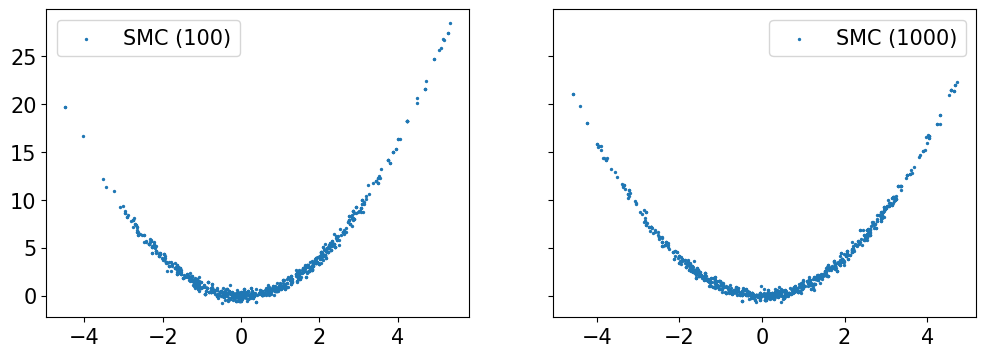

PyObject <matplotlib.legend.Legend object at 0x7fc512155190>

In [33]:
include("../Inversion/SMC.jl")
N_ens = 1000
step_length = 1.0
M_threshold = 0.6*N_ens


mutable struct Setup_Param{IT<:Int}
    θ_names::Array{String,1}
    N_θ::IT
    N_y::IT
end

s_param = Setup_Param(["θ₁", "θ₂"], 2, 2)


fig, ax = PyPlot.subplots(ncols=2, sharex=false, sharey=true, figsize=(12,4))

# N_t = 100
N_t = 100
smcobj = SMC_Run(s_param, func_G, μ0, Σ0,  y, Ση, N_ens, step_length, M_threshold, N_t;)
θ = smcobj.θ[end]
weights = smcobj.weights[end]
θ_p = copy(θ)
for i = 1:N_ens
    θ[i, :] .= θ_p[sample(Weights(weights)), :]
end
ax[1].scatter(θ[:, 1], θ[:, 2], s = 2,  label="SMC ($(N_t))")
ax[1].legend()

N_t = 1000
smcobj = SMC_Run(s_param, func_G, μ0, Σ0,  y, Ση, N_ens, step_length, M_threshold, N_t;)
θ = smcobj.θ[end]
weights = smcobj.weights[end]
θ_p = copy(θ)
for i = 1:N_ens
    θ[i, :] .= θ_p[sample(Weights(weights)), :]
end
ax[2].scatter(θ[:, 1], θ[:, 2], s = 2, label="SMC ($(N_t))")
ax[2].legend()

